In [14]:
library('RODBC')
library('quantmod')
library('PerformanceAnalytics')
library('colorspace')
library('extrafont')
source("/usr/common/config.R")
lcon <- odbcDriverConnect(sprintf("Driver={SQL Server};Server=%s;Database=%s;Uid=%s;Pwd=%s;", ldbserver, ldbname, ldbuser, ldbpassword), case = "nochange", believeNRows = TRUE)

In [11]:
#get the listing dates of all 'EQ' and 'BE' series stocks
allStarts<-sqlQuery(lcon, "select symbol, min(time_stamp), max(time_stamp) from px_history 
                            where (series='eq' or series='be')
                            and time_stamp >= '2010-01-01' and time_stamp < '2017-06-01'
                            group by symbol")

allStarts[,2]<-as.Date(allStarts[,2])
allStarts[,3]<-as.Date(allStarts[,3])
#remove delisted
allStarts<-allStarts[allStarts[,3] == max(allStarts[,3]),]

#print(allStarts)

In [23]:
cumRets<-data.frame(SYMBOL="", D0=0.0, D5=0.0, D10=0.0, D20=0.0, D50=0.0, D100=0.0, stringsAsFactors = F)

for(i in 1:length(allStarts[,1])){
    sym<-toString(allStarts[i,1])
    
    retSeries<-sqlQuery(lcon, sprintf("select time_stamp, daily_return from RETURN_SERIES_ALL 
                                        where symbol='%s' and time_stamp >='%s'", sym, allStarts[i,2]))
    
    retXts<-xts(retSeries[,2], as.Date(retSeries[,1]))
    
    ###! there should be a better way to do this !###
    d5<-ifelse(length(retXts) >= 6, Return.cumulative(retXts[2:6]), NA)
    d10<-ifelse(length(retXts) >= 11, Return.cumulative(retXts[2:11]), NA)
    d20<-ifelse(length(retXts) >= 21, Return.cumulative(retXts[2:21]), NA)
    d50<-ifelse(length(retXts) >= 51, Return.cumulative(retXts[2:51]), NA)
    d100<-ifelse(length(retXts) >= 101, Return.cumulative(retXts[2:101]), NA)
    
    cumRets<-rbind(cumRets, c(sym, retXts[1]*100, d5*100, d10*100, d20*100, d50*100, d100*100))
}

cumRets<-cumRets[-1,]
#print(cumRets)

Warning message:
“closing unused RODBC handle 1”

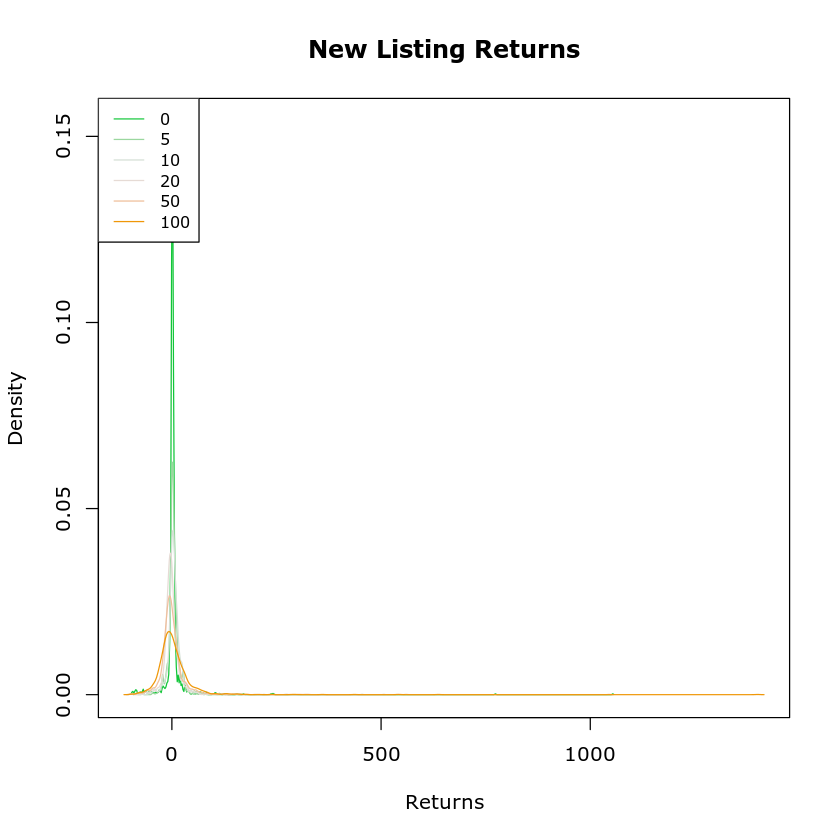

In [24]:
cumRets$D0<-as.numeric(cumRets$D0)
cumRets$D5<-as.numeric(cumRets$D5)
cumRets$D10<-as.numeric(cumRets$D10)
cumRets$D20<-as.numeric(cumRets$D20)
cumRets$D50<-as.numeric(cumRets$D50)
cumRets$D100<-as.numeric(cumRets$D100)

d0<-density(cumRets$D0, na.rm=T)
d5<-density(cumRets$D5, na.rm=T)
d10<-density(cumRets$D10, na.rm=T)
d20<-density(cumRets$D20, na.rm=T)
d50<-density(cumRets$D50, na.rm=T)
d100<-density(cumRets$D100, na.rm=T)

lineColors<-diverge_hcl(6, h = c(130, 43), c = 100, l = c(70, 90))

par(family='Verdana')
plot(range(d0$x, d5$x, d10$x, d20$x, d50$x, d100$x), range(d0$y, d5$y, d10$y, d20$y, d50$y, d100$y), type = "n", 
     ylab = "Density", xlab="Returns", main="New Listing Returns")

lines(d0, col=lineColors[1])
lines(d5, col=lineColors[2])
lines(d10, col=lineColors[3])
lines(d20, col=lineColors[4])
lines(d50, col=lineColors[5])
lines(d100, col=lineColors[6])
par(cex=0.8)
legend('topleft', legend=c('0', '5', '10', '20', '50', '100'), lty=1, col=lineColors)



In [30]:
summary(cumRets[,1], na.rm=T)
cumRets[cumRets[,1] > 50 & !is.na(cumRets[,1]),]

    Min.  1st Qu.   Median     Mean  3rd Qu.     Max.     NA's 
-98.7339  -9.5945  -2.6474   0.0415   5.2338 506.5164        4 

,SYMBOL,D0,D5,D10,D20,D50,D100
53,LICNFNHGP,2.2610,16.7213691,32.89465,120.1843,157.10354,NA
308,KIOCL,5.0000,25.7142696,59.04749,156.6664,NA,NA
510,SPCENET,-65.5172,49.9999906,100.00030,220.0006,49.99990,NA
602,QUESS,58.7066,119.3523846,454.76435,506.5164,538.22498,636.91819
723,FEL,4.9861,27.5437009,62.36375,106.4676,89.29432,22.65101
747,NFL,7.3815,-0.1446286,28.72666,104.2696,59.33446,57.81487
756,ASPINWALL,19.8716,66.3235556,152.14501,271.3213,181.40434,132.51733
927,THYROCARE,38.7444,161.0237990,151.88882,146.7310,125.85052,154.22700
1113,NATHBIOGEN,103.8835,27.3810773,61.90501,162.6196,326.19224,297.14422
1128,APOLSINHOT,31.2264,27.6060351,62.04175,103.2708,43.06271,29.40322
